<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 8: Image Classification

In the previous practical we created some images of handwritten digits and explored several image pre-processing and manipulation methods. So, now we are ready to train a model to classify the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which contains 70,000 images of handwritten digits, and is often used for understanding image classification. We will explore several unsupervised and supervised approaches, using the MNIST dataset for training and keep ours as an additional test set.

In the first part of this practical we will explore two supervised classification algorithms, Naive Bayes and Artificial Neural Network (ANN) for image classification. For the latter we can visualise the weights to gain insight into how the model distinguishes between the digits.

In the second part of this practical we will look at several unsupervised algorithms. UMAP (Uniform Manifold Approximation and Projection), a non-linear dimension reduction technique, and HDBSCAN (Hierarchical Density-Based Spatial Clustering and Application with Noise), is a hierarchical clustering algorithm which separates clusters of high density from low density.

The objectives of this practical are:

1. Apply a complete MV workflow for image classification

2. Consider different aspects of applying an ANN to image data and compare and contrast with the generative Naive Bayes algorithm

3. Understand the advantages of non-linear dimensionality reduction and hierarchical clustering for unsupervised image classification

# 1 Supervised Image Classification

## 1.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from skimage import io
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras import models, layers
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the datasets folder (should be in shared/datasets/mnist)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'mnist')

# Set the directory to the data folder (should be in ML-LV/data/digits)
data_dir = os.path.join(path, 'data', 'digits')

## 1.1 Load and pre-process data

1. First load the full MNIST dataset by using the Keras function.

2. Then load our MNIST digits as a test set.

3. The next cell plots the distribution of the digits between the training and validation sets.

Number of training images = 60000
Number of validation images = 10000
Number of testing images = 10
Shape of the training images = (60000, 28, 28)


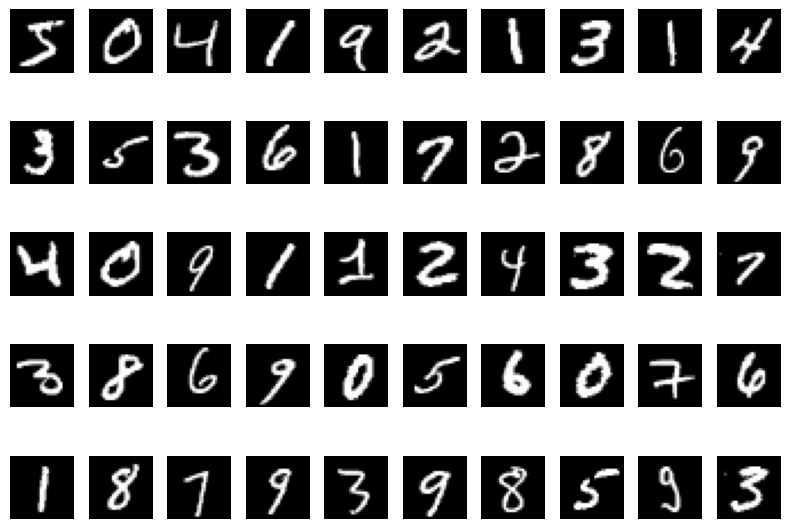

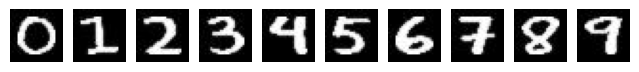

In [4]:
# Load the MNIST dataset
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data(path=os.path.join(datasets_dir, 'mnist.npz'))

# Load your own handwritten digits
X_test = np.empty((10, 28, 28), dtype=np.uint8)
for i in range(10):
    X_test[i] = io.imread(os.path.join(data_dir, 'my_digits_mnist', f'digit_{i}.jpg'))
y_test = np.arange(10)

# Display the number and shape of the images
print(f"Number of training images = {len(X_train)}")
print(f"Number of validation images = {len(X_val)}")
print(f"Number of testing images = {len(X_test)}")
print(f"Shape of the training images = {X_train.shape}")

# Display some digits
fig, ax = plt.subplots(5, 10, figsize=(8, 6))
ax = ax.ravel()
for i in range(50):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')
fig.tight_layout()
plt.show()

# Display your digits
fig, ax = plt.subplots(1, 10, figsize=(8, 6))
for i in range(10):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].axis('off')
plt.show()

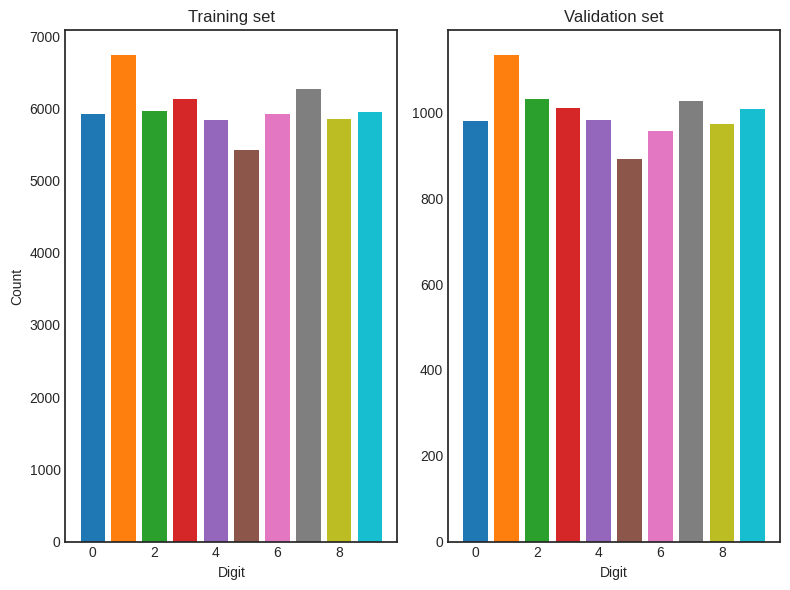

In [5]:
# Display the distribution of the digits
colours = plt.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1], color=colours(np.unique(y_train)/10))
ax[0].set_title('Training set')
ax[0].set_xlabel('Digit')
ax[0].set_ylabel('Count')
ax[1].bar(np.unique(y_val), np.unique(y_val, return_counts=True)[1], color=colours(np.unique(y_train)/10))
ax[1].set_title('Validation set')
ax[1].set_xlabel('Digit')
plt.tight_layout()
plt.show()

### Create the pre-processing pipeline

The images are currently two-dimensional (28x28 pixels), so we need to 'flatten' them into a single dimensional array so they are compatible with a standard feed forward NN. In this case we keep the first dimension (the number of images per batch) the same and flatten the 28x28 pixels into a single dimension of length 784. We will also normalise the pixel values to the range [0, 1].

In [6]:
# Define the pre-processing layers
processing_pipeline = tf.keras.Sequential([
    layers.Rescaling(1./255), # Normalise pixel values to the [0, 1] range
    layers.Lambda(lambda x: tf.reshape(x, (-1, x.shape[1]*x.shape[2]))) # Custom layer to flatten the images
], name='mnist_preprocessing')

print(f"Shape before pre-processing = {X_train.shape}")
X_train_processed = processing_pipeline(X_train)
print(f"Shape after pre-processing = {X_train_processed.shape}")

Shape before pre-processing = (60000, 28, 28)
Shape after pre-processing = (60000, 784)


## 1.2 Naive Bayes

### Train and evaluate the model

Validation Accuracy: 0.8357


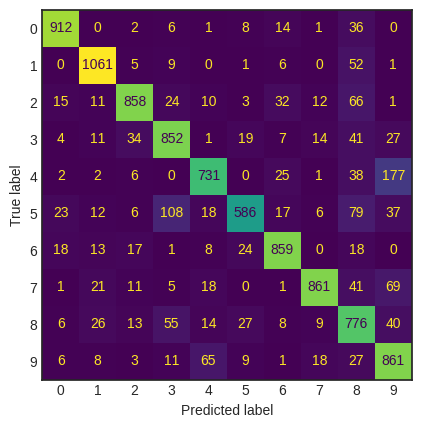

In [7]:
if not grading:
    # Create and train a Naive Bayes classifier
    nb_model = MultinomialNB()
    nb_model.fit(processing_pipeline(X_train), y_train)

    # Predict class labels for validation set
    predictions = nb_model.predict(processing_pipeline(X_val))
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, colorbar=False)
    plt.show()

### Evaluate the model on your MNIST digits

Test Accuracy: 0.4


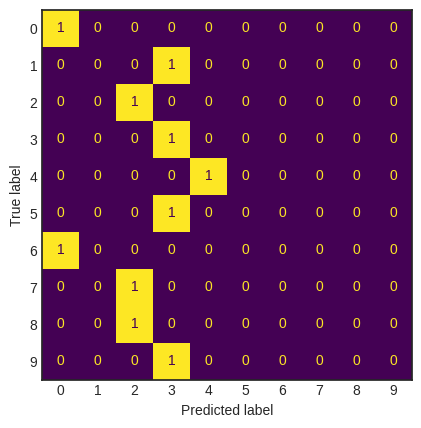

In [8]:
if not grading:
    # Predict class labels for test set
    predictions = nb_model.predict(processing_pipeline(X_test))
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, colorbar=False)
    plt.show()

### Visualise the model decision boundary

We can also reshape the log probabilities of each pixel (feature) back into the original 28x28 format. Then we can visualise the log probabilities for each class.

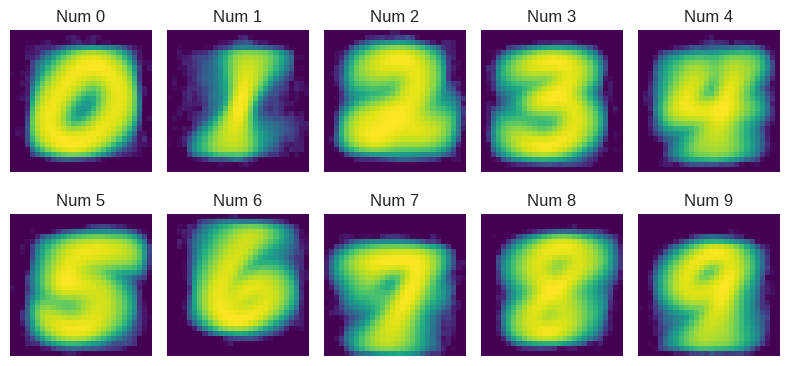

In [9]:
if not grading:
    # Convert the log probabilities to a numpy array of shape=(num_classes, 28, 28)
    log_probs = nb_model.feature_log_prob_.reshape(10, 28, 28)

    # Plot the weights
    fig, ax = plt.subplots(2, 5, figsize=(8, 4))
    ax = ax.ravel()
    for i in range(len(ax)):
        ax[i].imshow(log_probs[i], cmap='viridis')
        ax[i].axis('off')
        ax[i].set_title("Num {}".format(i))
    plt.tight_layout()
    plt.show()

## 1.3 Artificial Neural Network
This is just a simple single-layer network with 10 neurons, one for each class.

In [10]:
if not grading:
    # Input layer takes an image of size 28x28
    input = layers.Input(shape=(28, 28,), name='input')

    # Pass the image through the pre-processing pipeline
    x = processing_pipeline(input)

    # Single classification layer with 10 neurons
    output = layers.Dense(10, activation='softmax', name='output')(x)

    # Compile the model
    model = models.Model(inputs=input, outputs=output,  name='mnist_model')
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_preprocessing             │ (None, 784)            │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

Here we train the model using `model.fit()`, as before, but we will also save the layer weights after each epoch using a custom callback. Later we can visualise these weights to gain some insight into how the model learns to distinguish between the digits.

In [11]:
if not grading:
    model_earlystp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=5,
        verbose=0,
        mode="min",
        restore_best_weights=True)

    weights_dict = {}
    weight_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: weights_dict.update({epoch: model.get_weights()}))

    # Fit the model
    results = model.fit(X_train, y_train, epochs=100, batch_size=1000, validation_data=(X_val, y_val), callbacks=[model_earlystp, weight_callback], verbose=2)

Epoch 1/100
60/60 - 1s - 10ms/step - accuracy: 0.6481 - loss: 1.4084 - val_accuracy: 0.8155 - val_loss: 0.8705
Epoch 2/100
60/60 - 0s - 3ms/step - accuracy: 0.8349 - loss: 0.7325 - val_accuracy: 0.8656 - val_loss: 0.5976
Epoch 3/100
60/60 - 0s - 2ms/step - accuracy: 0.8664 - loss: 0.5620 - val_accuracy: 0.8835 - val_loss: 0.4928
Epoch 4/100
60/60 - 0s - 2ms/step - accuracy: 0.8800 - loss: 0.4828 - val_accuracy: 0.8933 - val_loss: 0.4363
Epoch 5/100
60/60 - 0s - 2ms/step - accuracy: 0.8897 - loss: 0.4364 - val_accuracy: 0.8986 - val_loss: 0.4010
Epoch 6/100
60/60 - 0s - 2ms/step - accuracy: 0.8955 - loss: 0.4052 - val_accuracy: 0.9025 - val_loss: 0.3754
Epoch 7/100
60/60 - 0s - 2ms/step - accuracy: 0.9001 - loss: 0.3829 - val_accuracy: 0.9065 - val_loss: 0.3572
Epoch 8/100
60/60 - 0s - 2ms/step - accuracy: 0.9036 - loss: 0.3659 - val_accuracy: 0.9097 - val_loss: 0.3438
Epoch 9/100
60/60 - 0s - 2ms/step - accuracy: 0.9061 - loss: 0.3528 - val_accuracy: 0.9109 - val_loss: 0.3329
Epoch 10/

Train loss: 0.250
Train accuracy: 0.931
Best validation loss: 0.262
Best validation accuracy: 0.928


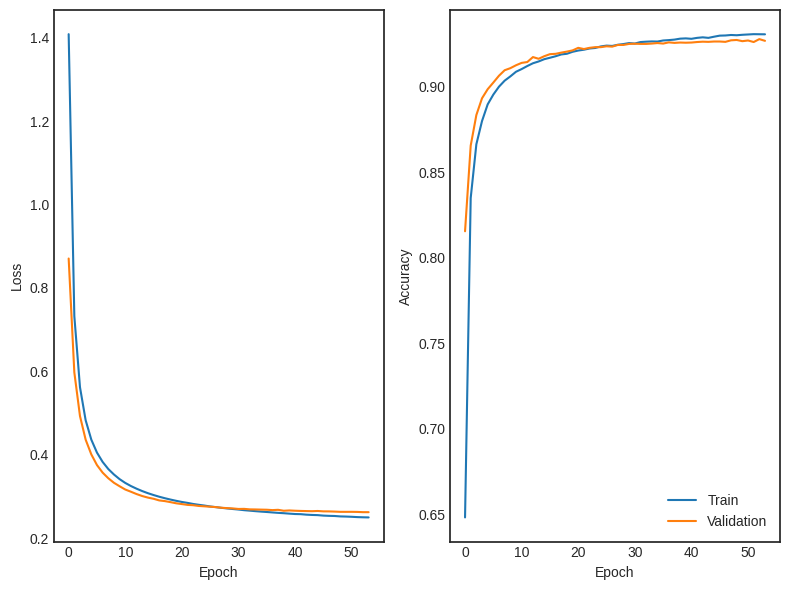

In [12]:
if not grading:
    # Show best loss and accuracy
    metrics = results.history
    print(f"Train loss: {min(metrics['loss']):.3f}")
    print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
    print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
    print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

    # Plot the training loss and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
    ax[0].plot(metrics['loss'], label='Train Loss')
    ax[0].plot(metrics['val_loss'], label='Validation Loss')
    ax[0].set(xlabel='Epoch', ylabel='Loss')
    ax[1].plot(metrics['accuracy'], label='Train Accuracy')
    ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
    ax[1].set(xlabel='Epoch', ylabel='Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

### Evaluate the model on your MNIST digits

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test Accuracy: 0.5


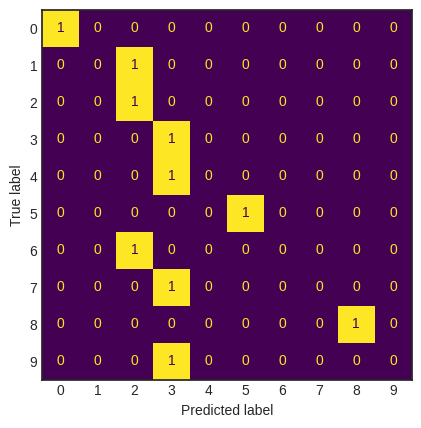

In [13]:
if not grading:
    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, colorbar=False)
    plt.show()

### Plot model weights

With a single-layer network we can reshape the weights back into the original 28x28 format. Then we can visualise the weights that were saved during training.

<div class="alert alert-success" style="color:black"><b>Note:</b> This code currently <b>only</b> works for a simple, single-layer, network. If you extend the network by adding layers you will need to choose which layer to visualise and select an appropriate dimension to reshape the image.</div>

In [14]:
if not grading:
    # Convert the saved weights to a numpy array of shape=(epochs, num_classes, 28, 28)
    weights = [np.asarray(np.transpose(weights_dict[i][0]).reshape(10, 28, 28)) for i in range(len(weights_dict))]
    weights = np.asarray(weights)

    # Plot the weights
    fig, ax = plt.subplots(2, 5, figsize=(8, 4))
    ax = ax.ravel()
    an_ax = []
    for j in range(len(ax)):
        an_ax.append(ax[j].imshow(weights[0][j], cmap='viridis', animated=True))
        ax[j].axis('off')
    fig.suptitle("Epoch: {}     Accuracy: {:.2f}%".format(1, results.history['accuracy'][0] * 100))

    # Define the animation function
    def animate_mnist(i):
        for j in range(len(ax)):
            an_ax[j].set_data(weights[i][j])
            ax[j].axis('off')
        fig.suptitle("Epoch: {}     Accuracy: {:.2f}%".format(i+1, results.history['accuracy'][i] * 100))
        return an_ax

    # Create the animation
    anim = FuncAnimation(fig, animate_mnist,  frames=weights.shape[0], interval=500, repeat=True, repeat_delay=1000, blit=True)
    html = HTML(anim.to_jshtml())
    display(html)
    plt.close()

<div class="alert alert-info" style="color:black"><h2>1.3 Exercise: Extend the model</h2>

You may find the single-layer network does not perform that well on your handwritten digits. Try extending the model by adding some hidden-layers, and even dropout, to see if it improves performance the the MNIST test set and your own small dataset.

We will use similar method signature as the exercise in week 3. The main difference is that this model should be a Keras *functional* model, *not sequential*. You should also include the preprocessing layers within the model itself, instead of a separate sequential model.

1. In the following cell complete the `build_model()` function. It should take in the following arguments: and return a Keras functional model.
    - `input_size` is the input shape.
    - `layers_list` is a list of tuples containing the number of neurons and activation function for each hidden layer. Thus the length of the list is also the number of hidden layers. For example: `[(10, 'sigmoid'), (5, 'sigmoid')]` is two layers with sigmoid activation and 10 and 5 units respectively. **Note:** this *does not* include the final output layer.
    - `dropout` is the dropout rate for each intermediate dropout layer after a hidden layer.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `output_activation` is the activation function for the output layer.
    - `optimiser` is the function for calculating the gradient and updating the weights e.g. SGD.
    - `loss` is the loss function for calculating the error of the model.
    - `name` is just a name to identify the model.

2. Once all the layers are implemented the function should compile the model with the given optimiser, loss and the accuracy metric (`metrics=["accuracy"]`).

3. Finally, return the compiled model.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [126]:
def build_model(input_size, layers_list, dropout, n_class, output_activation, optimiser, loss, name):
    """Build a simple ANN model

    Arguments:
        input_size (tuple): Input shape
        layers_list (list): A list of tuples containing the number of neurons (int) and activation function (str) for each hidden layer
        dropout (int): The dropout rate
        n_class (int): Number of classes
        output_activation (str): Activation function for the output layer
        optimiser (str): Optimiser to use
        loss (str): Loss function to use
        name (str): Name of the model
    """
    # YOUR CODE HERE
    # adapted to W3 3-1_supervised_classfication and use the keras u
    
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, Dropout, Input, Rescaling, Lambda
    from tensorflow.keras.optimizers import SGD
    
    # Define the model
    inputs = Input(shape=input_size, name='input_layer')
    x = Rescaling(1./255)(inputs)
    # Custom layer to flatten the images adapted to previous exercises
    x = Lambda(lambda x: tf.reshape(x, (-1, x.shape[1]*x.shape[2])))(x)

    # Adding hidden layers and dropout layers
    for units, activation in layers_list:
        # Adding dense layer
        x = Dense(units=units, activation=activation)(x)
        # Adding dropout layer after each hidden layer
        x = Dropout(rate=dropout)(x)

    # Adding output layer
    outputs = Dense(units=n_class, activation=output_activation)(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name=name)

    # Check how many layers
    print("Number of layers:", len(model.layers))

    
    # Compiling the model with optimiser, loss, and accuracy metric
    if optimiser == 'sgd':
        optimiser = SGD(learning_rate=0.01)
    model.compile(
        optimizer=optimiser,
        loss=loss,
        metrics=['accuracy']
    )

    return model

model = build_model((28, 28,), [(64, 'relu'), (32, 'relu')], 0.2, 10, 'softmax', 'sgd', 'sparse_categorical_crossentropy', 'a_model')

model.summary()

Number of layers: 8


Model: "a_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_81 (Rescaling)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_70 (Lambda)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Test cell (3 marks)

# Create a model using the build_model function
model = build_model((28, 28,), [(64, 'relu'), (32, 'relu')], 0.2, 10, 'softmax', 'sgd', 'sparse_categorical_crossentropy', 'a_model')

# Test the size of the input shape
assert model.input_shape == (None, 28, 28), 'Input shape should be (None, 28, 28)'

# Test the number of layers
assert len(model.layers) == 8, 'Model should have 8 layers'

# Test first layer is rescaling
assert model.layers[1].name.split('_')[0] == 'rescaling', 'First layer should be rescaling'

# Test second layer is lambda
assert model.layers[2].name.split('_')[0] == 'lambda', 'Second layer should be lambda'

# Test the number of neurons in the first hidden layer
assert model.layers[3].units == 64, 'First hidden layer should have 64 neurons'

# Test the activation function of the first hidden layer
assert model.layers[3].activation.__name__ == 'relu', 'First hidden layer should have relu activation'

# Test there is a dropout layer after the first hidden layer
assert isinstance(model.layers[4], layers.Dropout), 'Second hidden layer should have a dropout layer'

# Test the dropout rate
assert model.layers[4].rate == 0.2, 'Dropout rate should be 0.2'

# Test the number of neurons in the second hidden layer
assert model.layers[5].units == 32, 'Second hidden layer should have 32 neurons'

# Test the activation function of the second hidden layer
assert model.layers[5].activation.__name__ == 'relu', 'Second hidden layer should have relu activation'

# Test there is a dropout layer after the second hidden layer
assert isinstance(model.layers[6], layers.Dropout), 'Second hidden layer should have a dropout layer'

# Test the loss function
assert model.loss == 'sparse_categorical_crossentropy', 'Loss should be sparse_categorical_crossentropy'

# Test the learning rate
assert model.optimizer.learning_rate == 0.01, 'Learning rate should be 0.01'

# Test the optimiser
assert model.optimizer.name == 'SGD', 'Optimizer should be SGD'

# Test the name
assert model.name == 'a_model', 'Model name should be a_model'

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of parameters
assert model.count_params() == 52650, 'Model should have 52650 parameters'

print('All tests passed!')

Number of layers: 8
All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests all function parameters with different values


<div class="alert alert-info" style="color:black"><h2>1.4 Exercise: Build a model for classifying the MNIST digits</h2>

Once you have the `build_model()` function working correctly, select some appropriate parameters and build a model for classifying the MNIST digits. Adhere to the following constraints:

1. Ensure you use the appropriate input shape.

2. Do not create more than 4 hidden layers.

3. The total number of parameters should be < 25,000.

Once you have built a model you can use the test cell below to train and evaluate it. You should easily be able to improve the accuracy to > 95%, with a loss < 0.2.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [193]:
# YOUR CODE HERE

# build a model for classifying the MNIST digits
model = build_model(
    input_size=(28, 28,),
    # 30,23,20 or 28,41,35
    layers_list=[
        (28, 'relu'), # First hidden layer
        (41, 'relu'), # Second hidden layer
        (35, 'relu')], # Third hidden layer
    dropout=0.3,
    n_class=10,
    output_activation='softmax', # Output activation
    optimiser='adam',
    loss='sparse_categorical_crossentropy', # Loss function
    name='mnist_model'
)


model.summary()

Number of layers: 10


Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_135 (Rescaling)       │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_124 (Lambda)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_516 (Dense)               │ (None, 28)             │        21,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_369 (Dropout)           │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 41)             │         1,189 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_370 (Dropout)           │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_518 (Dense)               │ (None, 35)             │         1,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_371 (Dropout)           │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 10)             │           360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,999 (97.65 KB)

 Trainable params: 24,999 (97.65 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# Test cell (3 marks)

# Test the size of the input shape
assert model.input_shape == (None, 28, 28), 'Input shape should be (None, 28, 28)'

# Test the number of layers
assert len(model.layers) <= 12, 'Model should not have more than 12 layers (input + 2 preprocessing + 4 hidden + 4 dropout + 1 output)'

# Test the number of parameters
assert model.count_params() <= 25000, 'Model should not have more than 25,000 parameters'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests output layer and loss function are appropriate for this problem


In [195]:
if not grading:
    model_earlystp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
        verbose=0,
        mode="min",
        restore_best_weights=True)
    
    # Fit the model
    results = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_data=(X_val, y_val), callbacks=[model_earlystp], verbose=2)
    
    best_val_accuracy = max(results.history['val_accuracy'])
    best_val_loss = min(results.history['val_loss'])
    print(f"Best validation accuracy: {best_val_accuracy:.3f}")
    print(f"Best validation loss: {best_val_loss:.3f}")
    # Test the best validation accuracy and loss
    assert best_val_accuracy > 0.95, 'Validation accuracy should be greater than 95%'
    assert best_val_loss < 0.2, 'Validation loss should be less than 0.2'

Epoch 1/50
60/60 - 1s - 18ms/step - accuracy: 0.3110 - loss: 1.8991 - val_accuracy: 0.7592 - val_loss: 1.1016
Epoch 2/50
60/60 - 0s - 4ms/step - accuracy: 0.6285 - loss: 1.1096 - val_accuracy: 0.8816 - val_loss: 0.4788
Epoch 3/50
60/60 - 0s - 4ms/step - accuracy: 0.7520 - loss: 0.7764 - val_accuracy: 0.9039 - val_loss: 0.3555
Epoch 4/50
60/60 - 0s - 3ms/step - accuracy: 0.7999 - loss: 0.6488 - val_accuracy: 0.9161 - val_loss: 0.2986
Epoch 5/50
60/60 - 0s - 4ms/step - accuracy: 0.8239 - loss: 0.5874 - val_accuracy: 0.9198 - val_loss: 0.2852
Epoch 6/50
60/60 - 0s - 4ms/step - accuracy: 0.8387 - loss: 0.5448 - val_accuracy: 0.9246 - val_loss: 0.2657
Epoch 7/50
60/60 - 0s - 4ms/step - accuracy: 0.8481 - loss: 0.5158 - val_accuracy: 0.9304 - val_loss: 0.2454
Epoch 8/50
60/60 - 0s - 4ms/step - accuracy: 0.8575 - loss: 0.4918 - val_accuracy: 0.9330 - val_loss: 0.2369
Epoch 9/50
60/60 - 0s - 3ms/step - accuracy: 0.8649 - loss: 0.4677 - val_accuracy: 0.9345 - val_loss: 0.2297
Epoch 10/50
60/60 

<div class="alert alert-info" style="color:black"><h2>1.5 Exercise: Naive Bayes and ANN accuracy on your MNIST digits</h2>

In general the Naive Bayes algorithm and ANN probably performed much worse on the few MNIST digit images you created.

Why might this be and what could be done to resolve this issue?

<br>
<b>This exercise is <u>not</u> marked.</b>
</div>

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280